# Skin Cancer Detection using MLCV

### Installer des bibliothèques et faire les imports nécessaires

In [46]:
%pip install tensorflow
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install pydot
%pip install pydot graphviz
%pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras import Input
from tensorflow.keras.applications import EfficientNetB0 # type: ignore #ingore the warning
from tensorflow.keras.layers import Concatenate, Input, Dense, Dropout, Flatten, GlobalAveragePooling2D # type: ignore #ingore the warning
from tensorflow.keras.models import Model, Sequential # type: ignore #ingore the warning
from tensorflow.keras.optimizers import Adam # type: ignore #ingore the warning
from tensorflow.keras.utils import plot_model # type: ignore #ingore the warning
from tensorflow.keras.preprocessing.image import load_img, img_to_array # type: ignore #ingore the warning
from tensorflow.keras.applications.efficientnet import preprocess_input # type: ignore #ingore the warning
from tensorflow.keras.callbacks import TensorBoard # type: ignore #ingore the warning
from tensorflow.keras.metrics import Precision, Recall # type: ignore #ingore the warning
from sklearn.model_selection import train_test_split



### Définition de la fonction de traçage de courbes

In [48]:
def display_training_curves(training, validation, title, subplot):
    """
    Titre: Afficher les courbes d'entraînement

    Description:
    Cette fonction trace les courbes d'entraînement et de validation pour une métrique donnée (par exemple, précision, perte) au fil des époques.
    Elle configure les sous-graphiques, personnalise l'apparence et ajoute des légendes et des étiquettes pour une meilleure visualisation.

    Arguments:
        training (liste ou tableau): Les points de données d'entraînement à tracer.
        validation (liste ou tableau): Les points de données de validation à tracer.
        title (str): Le titre du graphique, généralement le nom de la métrique tracée.
        subplot (int): L'index du sous-graphe à utiliser pour le graphique actuel (1 ou 2).

    Retour:
        Aucun
    """
    if subplot == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    plt.subplot(2, 1, subplot)  # S'assurer d'avoir un bon placement dans la grille (2x1)
    plt.gca().set_facecolor('#F8F8F8')  # change the background color
    plt.plot(training)
    plt.plot(validation)
    plt.title('model ' + title)
    plt.ylabel(title)
    plt.xlabel('epoch')
    plt.legend(['train', 'valid.'])

### Détecter le hardware à disposition (TPU, GPU ou CPU dans cet ordre de priorité)
La variable `strategy` détermine le matériel disponible (TPU, GPU ou CPU) et le nombre de répliques synchronisées (`strategy.num_replicas_in_sync`). Cette information sera utilisée pour adapter dynamiquement le `BATCH_SIZE` global, en le multipliant par le nombre de répliques, afin d'optimiser l'entraînement selon les ressources disponibles.

In [49]:
# Detect hardware
try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu = None
#If TPU not found try with GPUs
  gpus = tf.config.experimental.list_logical_devices("GPU")
    
# Select appropriate distribution strategy for hardware
if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
  print('Running on TPU ', tpu.master())  
elif len(gpus) > 0:
  strategy = tf.distribute.MirroredStrategy(gpus) # this works for 1 to multiple GPUs
  print('Running on ', len(gpus), ' GPU(s) ')
else:
  strategy = tf.distribute.get_strategy()
  print('Running on CPU')

# How many accelerators do we have ?
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on CPU
Number of accelerators:  1


### Définition des paramètres globaux pour l'entrainement du modèle

In [50]:
# Chemins vers les fichiers TFRecord (désactivé dans cet exemple)
# TRAINING_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/train*')
# TEST_FILENAMES = tf.io.gfile.glob(GCS_DS_PATH + '/tfrecords/test*')

# Taille des lots adaptée au nombre de répliques (dispositifs GPU/TPU) disponibles

##################################
# rajout conidtion si GPU ou TPU #
##################################
BATCH_SIZE = 32 * strategy.num_replicas_in_sync  # Par exemple, 10 images par réplique

# Taille des images à utiliser (100x100 pixels)
IMAGE_SIZE = [100, 100]  # Taille utilisée pour le redimensionnement des images
imSize = 100             # Taille utilisée pour redimensionner les images dans les pipelines

# Optimisation automatique pour le préchargement des données
AUTO = tf.data.experimental.AUTOTUNE

# Nombre d'époques (itérations sur l'ensemble d'entraînement)
EPOCHS = 10  # Peut être ajusté en fonction des performances et de la convergence

# Définir l'entrée du modèle (couche d'entrée pour TensorFlow/Keras)
input_layer = Input(shape=(imSize, imSize, 3))  # Entrée avec une image RGB (3 canaux)

## Traitement des métadonnées, classifications en batch (train, validate, test) et création des dataset TensorFlow

### Chargement et prétraitement des métadonnées

In [ ]:
# Chargement du fichier CSV contenant les métadonnées
metadata = pd.read_csv("./Data/train.csv")
    
# Ajouter les chemins complets des images
metadata['image_path'] = metadata['image_name'].apply(lambda x: f"./Data/train/{x}.jpg")

metadata['label'] = metadata['benign_malignant'].map({'benign': 0, 'malignant': 1})


# Supprimer les lignes avec des valeurs manquantes
metadata = metadata.dropna(subset=['label'])

metadata = metadata [['image_path', 'label']]

print(f"Nombre total d'images disponibles : {len(metadata)}")
print(f"Total rows in original CSV: {metadata.shape[0]}")

Des valeurs manquantes ont été détectées.
Nombre total d'images disponibles : 33126
Total rows in original CSV: 33126


In [77]:
# Affiche le nombre  d'images par classe
print(metadata['label'].value_counts())

# Prendre un échantillon aléatoire de 10 000 images
metadata = metadata.sample(n=10000, random_state=42)
print(metadata['label'].value_counts())
# Afficher la taille du nouvel échantillon
print(f"Nombre d'images après échantillonnage : {len(metadata)}")

label
0    32542
1      584
Name: count, dtype: int64
label
0    9813
1     187
Name: count, dtype: int64
Nombre d'images après échantillonnage : 10000


### Division des données en ensembles d’entraînement, validation et test

À cette étape, les données sont divisées en trois ensembles distincts : **entraînement**, **validation**, et **test**, afin de préparer le modèle pour son entraînement et son évaluation. Tout d'abord, 70 % des données sont affectées à l'ensemble d'entraînement, qui sera utilisé pour ajuster les paramètres du modèle. Les 30 % restants sont répartis entre les ensembles de validation (20 % des données totales) et de test (10 % des données totales). La stratification est appliquée sur la variable `label` pour garantir que les proportions des classes (par exemple, "Malignant" et "Benign") sont similaires dans les trois ensembles. Cette méthode assure une représentation équilibrée des classes dans chaque ensemble, ce qui est essentiel pour éviter les biais dans l'évaluation des performances du modèle.

La stratification consiste à répartir les données de manière à ce que la proportion de chaque classe soit conservée dans les sous-ensembles créés (entraînement, validation, test). Cela garantit que les ensembles reflètent fidèlement la distribution initiale des classes, évitant les déséquilibres qui pourraient biaiser l'entraînement ou l'évaluation du modèle.

In [103]:
# Mélanger les données initiales
metadata = metadata.sample(frac=1, random_state=42).reset_index(drop=True)

# Division des ensembles en entraînement (70%), validation (20%), et test (10%)
# training_metadata = metadata.sample(frac=0.8, random_state=42)
# validation_metadata = metadata.drop(training_metadata.index)
train_size = int(0.7 * len(metadata))  # 70% pour l'entraînement
val_size = int(0.2 * len(metadata))    # 20% pour la validation
test_size = len(metadata) - train_size - val_size  # 10% pour le test

training_metadata = metadata.iloc[:train_size]
validation_metadata = metadata.iloc[train_size:train_size + val_size]
test_metadata = metadata.iloc[train_size + val_size:]

print(f"Entraînement : {training_metadata.shape[0]} exemples")
print(f"Validation : {validation_metadata.shape[0]} exemples")
print(f"Test : {test_metadata.shape[0]} exemples")

####################################################################################
# ??? Ajouter la fonction de création des datasets pour TensorFlow juste après ??? #
####################################################################################

Entraînement : 7000 exemples
Validation : 2000 exemples
Test : 1000 exemples


Vérifications sur les datasets splités.

In [105]:
print("Class distribution in training set:")
print(training_metadata['label'].value_counts(normalize=True))
print("Class distribution in validation set:")
print(validation_metadata['label'].value_counts(normalize=True))
print("Class distribution in test set:")
print(test_metadata['label'].value_counts(normalize=True))

total_samples = training_metadata.shape[0] + validation_metadata.shape[0] + test_metadata.shape[0]
print(f"Total samples: {total_samples} (original: {metadata.shape[0]})")

# Check pour des overlaps entre les sets de données (data leakage), retourne une erreur si overlap
assert len(set(training_metadata.index) & set(validation_metadata.index)) == 0, "Overlap between train and validation sets!"
# assert len(set(val_metadata.index) & set(test_metadata.index)) == 0, "Overlap between validation and test sets!"

Class distribution in training set:
label
0    0.981286
1    0.018714
Name: proportion, dtype: float64
Class distribution in validation set:
label
0    0.982
1    0.018
Name: proportion, dtype: float64
Class distribution in test set:
label
0    0.98
1    0.02
Name: proportion, dtype: float64
Total samples: 10000 (original: 10000)


### Définition des fonctions pour charger et prétraiter les données
À cette étape, le code prépare un pipeline de traitement des images pour l'entraînement du modèle. Les images sont chargées à partir de leurs chemins, redimensionnées à une taille standard de 100x100 pixels, normalisées (valeurs entre 0 et 1), et associées à leurs étiquettes (labels). Ces transformations sont encapsulées dans une fonction `load_image_and_label`, appliquée via `tf.data.Dataset` pour créer un ensemble de données TensorFlow optimisé. Enfin, les données sont divisées en lots et préchargées pour accélérer l'entraînement.

In [115]:
# Fonction pour charger et prétraiter une image
def load_image_and_label(image_path, label):
    """
    Charge une image depuis son chemin, applique des prétraitements
    (normalisation, redimensionnement), et retourne l'image et son étiquette.
    """
    # Charger l'image depuis son chemin
    image = tf.io.read_file(image_path)  # Lire le fichier image
    image = tf.image.decode_jpeg(image, channels=3)  # Décode une image JPEG en RGB
    
    # Normaliser les valeurs des pixels (entre 0 et 1)
    image = tf.cast(image, tf.float32) / 255.0
    
    # Redimensionner l'image à une taille standard
    image = tf.image.resize(image, [imSize, imSize])

    label = tf.cast(label, tf.int64)
    
    return image, label

# Fonction pour convertir un DataFrame Pandas en dataset TensorFlow
def create_tf_dataset(metadata_df, batch_size):
    """
    Convertit un DataFrame contenant les chemins des images et les labels 
    en un dataset TensorFlow optimisé pour l'entraînement.
    """
    # Extraction des colonnes nécessaires depuis le DataFrame
    image_paths = metadata_df['image_path'].values
    labels = metadata_df['label'].values
    
    # Créer un dataset TensorFlow à partir des chemins et des étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(
        lambda image_path, label: load_image_and_label(image_path, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    
    # Appliquer la fonction de chargement et de prétraitement à chaque image du dataset
    # dataset = dataset.map(load_image_and_label, num_parallel_calls=AUTO)
    
    dataset = dataset.repeat()

    dataset = dataset.shuffle(1500)  # Mélange avec un tampon de 1500 éléments

    # Diviser en lots et activer le préchargement pour optimiser les performances
    dataset = dataset.batch(batch_size)
    dataset= dataset.prefetch(AUTO)

    
    return dataset

def create_tf_test_dataset(metadata_df, batch_size):
    """
    Convertit un DataFrame contenant les chemins des images et les labels 
    en un dataset TensorFlow optimisé pour l'entraînement.
    """
    # Extraction des colonnes nécessaires depuis le DataFrame
    image_paths = metadata_df['image_path'].values
    labels = metadata_df['label'].values
    dataset = tf.data.Dataset.from_tensor_slices(metadata_df.to_dict('list'))
    
    # Créer un dataset TensorFlow à partir des chemins et des étiquettes
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))

    dataset = dataset.map(
        lambda image_path, label: load_image_and_label(image_path, label),
        num_parallel_calls=tf.data.AUTOTUNE
    )

    # Diviser en lots et activer le préchargement pour optimiser les performances
    dataset = dataset.batch(batch_size)
    dataset= dataset.prefetch(AUTO)

    
    return dataset

#### Test d'affichage de quelques images du dataset (depuis le pipeline TensorFlow)
Cette étape permet de vérifier si les images ont été correctement redimensionnées en prenant aléatoirement 5 images.

In [116]:
# # Visualiser 5 images aléatoires depuis le pipeline TensorFlow
# for image, label in create_tf_dataset(metadata.sample(frac=1).reset_index(drop=True), batch_size=1).take(5):
#     # Convertir le tenseur en tableau NumPy pour l'affichage
#     img_resized = image[0].numpy()
#     plt.imshow(img_resized)
#     # Afficher le label avec le mapping 0 -> Benign, 1 -> Malignant
#     plt.title(f"{'Benign' if label.numpy() == 0 else 'Malignant'}")
#     plt.axis('off')  # Supprimer les axes pour une meilleure visualisation
#     plt.show()

### Création des datasets TensorFlow

Cette étape transforme les sous-ensembles (entraînement, validation et test) en pipelines optimisés pour TensorFlow à l'aide de `create_tf_dataset`. Chaque dataset contient des images prétraitées (chargées, redimensionnées, et normalisées) associées à leurs labels, regroupées en lots de taille spécifiée (`BATCH_SIZE`). Ces datasets sont utilisés directement par le modèle lors de l'entraînement ou de l'évaluation pour assurer une gestion efficace des données.

In [ ]:
# Créer les datasets
training_dataset = create_tf_dataset(training_metadata, batch_size=BATCH_SIZE)
validation_dataset = create_tf_dataset(validation_metadata, batch_size=BATCH_SIZE)
test_dataset = create_tf_test_dataset(test_metadata, batch_size=BATCH_SIZE)

print(f"Test dataset : {len(test_dataset)}")
# print(f"Test dataset : {len(test_dataset)} batches")

Training dataset : 32


### Calcul des paramètres pour l’entraînement

Les paramètres `STEPS_PER_EPOCH` et `VALIDATION_STEPS` déterminent le nombre de lots nécessaires pour parcourir une fois l'ensemble des données d'entraînement ou de validation. Ils sont calculés en divisant la taille totale des données par `BATCH_SIZE` pour garantir que le modèle traite toutes les données à chaque époque, tout en optimisant l'utilisation des ressources.

In [88]:
# Calcul des paramètres pour l'entraînement
# STEPS_PER_EPOCH = len(training_dataset) // BATCH_SIZE
# VALIDATION_STEPS = len(validation_dataset) // BATCH_SIZE 
steps_per_epochs = len(training_metadata) // BATCH_SIZE
validation_steps = len(validation_metadata) // BATCH_SIZE

print(f"Nombre d'étapes pour l'entraînement : {steps_per_epochs}")
print(f"Nombre d'étapes pour la validation : {validation_steps}")

Nombre d'étapes pour l'entraînement : 250
Nombre d'étapes pour la validation : 62


### Charger le modèle (sans couche de classification finale)

In [89]:
# Charger le modèle EfficientNetB0 préentraîné sans la couche de classification finale
with strategy.scope():
    base_model = tf.keras.Sequential([
        EfficientNetB0(
            input_shape=(imSize, imSize, 3),
            weights='imagenet',
            include_top=False
        )
    ])

# Geler les couches du modèle de base pour conserver les poids préentraînés
base_model.trainable = False

In [90]:
# Passer l'entrée à travers le modèle de base
x = base_model(input_layer, training=False)  # `input_layer` 
x = Flatten()(x)  # Aplatir les caractéristiques extraites

# Ajout de couches fully connected pour la classification
x = Dense(128, activation="relu")(x)  # Couche dense
x = Dropout(0.5)(x)  # Dropout pour régularisation
output = Dense(1, activation="sigmoid")(x)  # Sigmoid pour une classification binaire

# Définir le modèle final avec une seule entrée (image)
model = Model(inputs=input_layer, outputs=output)

### Compiler le modèle

In [91]:
# Calcul des poids des classes
# class_weights = {0: 1.0, 1: 9.0}  # Augmenter le poids de la classe "malin"
# Ajustez le poids en fonction de l'importance de chaque classe dans votre dataset

# Créez une fois les objets Precision et Recall
# precision = Precision()
# recall = Recall()

# def f1_score(y_true, y_pred):
#     """
#     Calcul du F1 score basé sur la précision et le rappel.
#     """
#     p = precision(y_true, y_pred)
#     r = recall(y_true, y_pred)
#     return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

model.compile(
    optimizer='adam',  # Optimiseur Adam
    loss="binary_crossentropy",          # Fonction de perte pour la classification binaire
    metrics=["accuracy"]  # Suivi de la précision
)

# Résumé du modèle
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 20480)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     2,621,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,671,268 (25.45 MB)

 Trainable params: 2,621,697 (10.00 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [69]:
# Visualisation de l'architecture du modèle
# plot_model(model, show_shapes=True, to_file="efficientnetb0_model.png")

In [92]:
def learning_rate_function(epoch):
    LR_START = 0.001 # Taux d'apprentissage initial
    LR_MAX = 0.00005 * strategy.num_replicas_in_sync # Taux d'apprentissage maximal
    LR_MIN = 0.00001 # Taux d'apprentissage minimal
    LR_RAMPUP_EPOCHS = 5 # nombre d'époques pendant lesquelles le taux d'apprentissage augmente linéairement.
    LR_SUSTAIN_EPOCHS = 0 # nombre d'époques où le taux reste maximal
    LR_EXP_DECAY = .8 # taux de décroissance exponentielle du taux d'apprentissage après les périodes de "ramp-up" et de "soutien"
    

    # Augmentation (pour les premières LR_RAMPUP_EPOCHS époques) : le taux d'apprentissage commence à LR_START et monte linéairement jusqu'à LR_MAX
    if epoch < LR_RAMPUP_EPOCHS: 
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START

    # Soutien (pour les LR_SUSTAIN_EPOCHS suivantes) : le taux d'apprentissage reste constant à LR_MAX
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    # Décroissance (pour les époques restantes) : le taux d'apprentissage diminue exponentiellement
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(learning_rate_function, verbose=1)

In [93]:
log_dir = os.path.join("logs", "fit", "model_name")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(training_dataset, steps_per_epoch=steps_per_epochs, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps,callbacks=[lr_schedule,tensorboard_callback],)

# tensorboard --logdir=logs/fit pour lancer TensorBoard


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 282s 984ms/step - accuracy: 0.9675 - loss: 0.4271 - val_accuracy: 0.9834 - val_loss: 0.0966 - learning_rate: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.00081.
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 238s 955ms/step - accuracy: 0.9843 - loss: 0.1205 - val_accuracy: 0.9798 - val_loss: 0.1007 - learning_rate: 8.1000e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.00062.
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 232s 932ms/step - accuracy: 0.9831 - loss: 0.1194 - val_accuracy: 0.9814 - val_loss: 0.0928 - learning_rate: 6.2000e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.00043000000000000004.
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 230s 919ms/step - accuracy: 0.9848 - loss: 0.1135 - val_accuracy: 0.9844 - val_loss: 0.0818 - learning_rate: 4.3000e-04

Epoch 5: LearningRateScheduler setting learning rate to 0.00023999999999999998.
Epoch 

### Affichage de l'évolution de "accuracy" et "loss" en fonction des époques

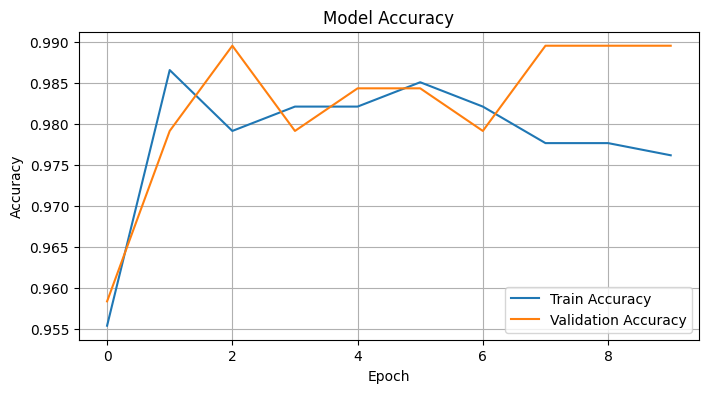

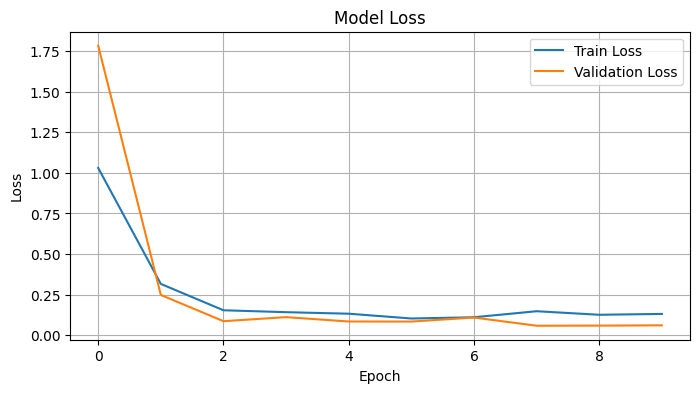

In [72]:
# Plot accuracy
plt.figure(figsize=(8, 4))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot loss
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

32/32 ━━━━━━━━━━━━━━━━━━━━ 24s 725ms/step


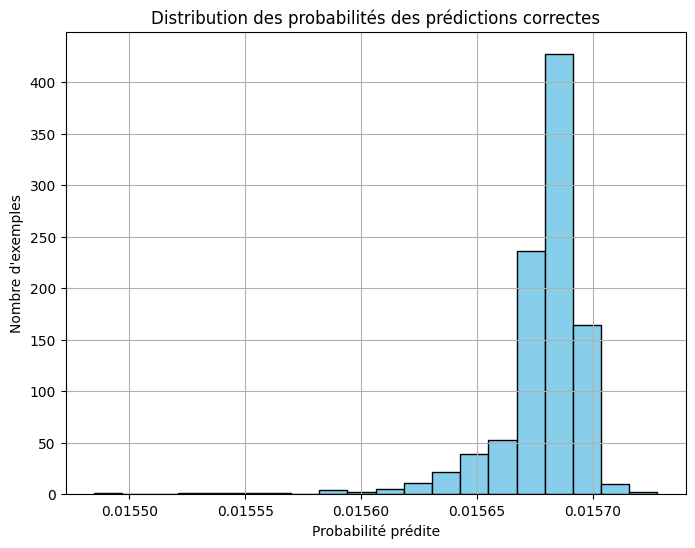

In [108]:
# Prédire les résultats sur le dataset de test
predictions = model.predict(test_dataset)

# Classification binaire (sigmoid), les prédictions sont des probabilités
predicted_probabilities = predictions.flatten()

# Convertir les probabilités en classes prédictes (seuil à 0.5 par défaut pour sigmoid)
predicted_classes = (predicted_probabilities >= 0.5).astype(int)

# Comparer avec les vraies étiquettes
true_labels = test_metadata['label'].values.astype(int)

# Identifier les indices des prédictions correctes
correct_indices = predicted_classes == true_labels

# Extraire les probabilités pour les prédictions correctes
correct_probabilities = predicted_probabilities[correct_indices]

# Tracer un histogramme des probabilités des prédictions correctes
plt.figure(figsize=(8, 6))
plt.hist(correct_probabilities, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution des probabilités des prédictions correctes')
plt.xlabel('Probabilité prédite')
plt.ylabel('Nombre d\'exemples')
plt.grid(True)
plt.show()
